In [1]:
import pandas as pd
import numpy as np
import importlib
import sys
import time
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, accuracy_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split

Pour être sûr d'utiliser Tensorflow 2.0 :

In [2]:
assert hasattr(tf, "function")

Cette fonction ouvre un fichier C_maps.txt en lecture et récupère les 22 coefficients et les retourne sous forme d'une matrice

In [3]:
def get_data(file_path):
    
    file = open(file_path, "r")

    allText = file.read()

    words = list(map(str, allText.split()))

    matrice_height = int(len(words) / 30)
    matrice = np.ones((matrice_height, 24))

    emplacement = 20
    iter1 = 0
    for i in range(emplacement, int(len(words) / 30) + emplacement):
        iter2 = 0
        for j in range(emplacement + 6, emplacement + 30):
            matrice[(iter1, iter2)] = words[j]
            iter2 += 1
        iter1 += 1
        emplacement += 30
    X_2 = np.delete(matrice, 1, 1)
    X_final = np.delete(X_2, 10, 1)
    
    file.close()
    
    return X_final

Cette fonction ouvre un fichier ctf en lecture et récupère les 3 coefficients d'Euler pour les retourner sous forme de matrice (x, 3)

In [9]:
def read_ctf(file_path):
    
    file2 = open(file_path, "r")
    
    allText2 = file2.read()
    words2 = list(map(str, allText2.split()))
    
    nb_debut_donnees = 88
    nb_mots = len(words2) - nb_debut_donnees
    nb_mots_par_ligne = 11
    
    nb_ligne_matrice = int(nb_mots / nb_mots_par_ligne)
    print("nb_ligne_matrice = " + str(nb_ligne_matrice))
    nb_colonne_matrice = 3
    matrice = np.empty((nb_ligne_matrice, nb_colonne_matrice))
    emplacement = 0
    
    print("Extraction des données à partir du fichier ....")
    for i in range(nb_debut_donnees, nb_mots + nb_debut_donnees, nb_mots_par_ligne):
        matrice[(emplacement, 0)] = words2[i + 5]
        matrice[(emplacement, 1)] = words2[i + 6]
        matrice[(emplacement, 2)] = words2[i + 7]
        emplacement += 1
    print("ok !")    
    file2.close()
    
    return matrice

Cette fonction fait faire des prédiction au modèle et renvoie le score, mae, rmse, r2

In [10]:
def run_experiment(model):
    y_pred = model.predict(X_test)
    print("R^2 : ", r2_score(y_test, y_pred))
    print("MAE :", mean_absolute_error(y_test,y_pred))
    print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))

cette fonction renvoie le nombre d'erreur de 1 degré ou plus de la prédiction par rapport aux valeurs réelles
et renvoie les valeurs X d'entrée et y de sortie pour lesquels le modèle prédit mal, sous forme de matrices erreur_x, erreur_y

In [11]:
def pourcentage_erreur(y_pred, y_test, x_test):
   
    err = 0
    marge_derreur = 1 # 1 degre
    erreur_y = np.empty((1, 3), dtype=float)
    erreur_x = np.empty((1, 22), dtype=float)
   
    for i in range(y_pred.shape[0]):
       
        for j in range(y_pred.shape[1]):
           
            error = abs(y_pred[i][j] - y_test[i][j])
            if error >= marge_derreur:
               
                # print(error)
                err += 1
               
                erreur_y = np.append(erreur_y, [y_test[i]], axis=0)
                erreur_x = np.append(erreur_x, [x_test[i]], axis=0)
               
                break
               
    erreur_y = np.delete(erreur_y, 0, axis=0)
    erreur_x = np.delete(erreur_x, 0, axis=0)
    
    for y in erreur_y:
        for i in range(len(y)):
            y[i] = round(y[i], 3)
    for x in erreur_x:
        for j in range(len(x)):
            x[j] = round(x[j], 3)
    
    message = "le pourcentage d'erreur est de "+str((err / y_pred.shape[0]) * 100)+", "+str(err)+" / "+str(y_pred.shape[0])
    return message, erreur_y, erreur_x, err

X matrice d'entrée de dimension (250000, 22)

In [12]:
file_in_path = "C_maps_2.txt"
X = get_data(file_in_path)

Y matrice de dimension (250000, 3) correspondant aux valeurs de sortie q'on attend

In [13]:
file_out_path = "exercise2.ctf"

y = read_ctf(file_out_path)

nb_ligne_matrice = 250000
Extraction des données à partir du fichier ....
ok !


Nous divisons notre jeu de données en jeu d'entraînement, X_train, y_train et en jeu de test, X_test, y_test
le pourcentage de données de test est précisé avec le paramètre test_size, ici de 20%. random_state permet d'avoir le même mélange de données pour pouvoir comparer des modèles entre eux

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Importer un modèle qu'on a sauvegardé auparavant dans un fichier h5

In [17]:
model = keras.models.load_model('hasan.h5')

Ou on définit notre modèle, entrée de de taille 22 avec quatres couches intermédiaire composés de 256, 128, 64 et 32 neurones avec fonction d'activation Relu et dernière couche, de sortie, de taille 3

On définit notre optimiseur et la vitesse d'apprentissage

on précise à notre modèle notre fonction de perte mae, mean absolute error, l'optimiseur et le métrique

On entraîne le modèle en précisant nos données d'entraînement, X_train et y_train, le batch_size qui est le nombre de fois qu'on montre nos données au modèle avant qu'il ajuste ses paramètres, le nombre d'epochs qui est le nombre d'entraînement et nos données de valisation, X_test et y_test

Pour sauvegarder un modèle au format h5

on demande au modèle de faire des prédictions pour les valeurs de X_test, de dimension (50000, 22).
val_predictions aura une dimension de (50000, 3)

In [18]:
val_predictions = model.predict(X_test)

On affiche les dix premières valeurs de prédictions (val_predictions) et les valeurs réelles attendues (y_test)

In [19]:
print("y_test : \n", y_test[:10])
print("=====================================")
print("y_pred : \n", val_predictions[:10])

y_test : 
 [[ 24.184  56.919  46.449]
 [ 64.483  56.12   45.87 ]
 [ 98.644  56.907  41.406]
 [ 37.895  56.299  44.834]
 [181.811  56.657  47.114]
 [ 24.667  57.125  44.681]
 [170.13   55.825  45.57 ]
 [207.195  56.294  42.492]
 [ 92.085  57.012  48.459]
 [337.13   56.261  42.685]]
y_pred : 
 [[ 24.12245   56.895687  46.40291 ]
 [ 64.43709   56.11285   45.834408]
 [ 98.58372   56.9085    41.3583  ]
 [ 37.892517  56.265713  44.816925]
 [181.71324   56.62058   47.111393]
 [ 24.58314   57.095196  44.63226 ]
 [169.96227   55.80922   45.53617 ]
 [207.10796   56.258144  42.44156 ]
 [ 91.9759    56.984962  48.40717 ]
 [336.99966   56.21104   42.635372]]


On calcule l'erreur moyenne absolue en donnant à la fonction les valeurs prédites et réelles

In [20]:
val_mae = mean_absolute_error(val_predictions, y_test)
print("Validation MAE for Model: {}".format(val_mae))

Validation MAE for Model: 0.12463437332611109


On affiche trois graphiques pour chaque valeur d'Euler, en x les valeurs réelles et en y les valeurs prédites

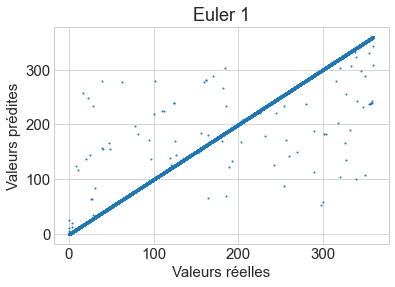

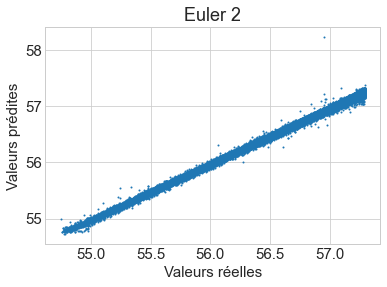

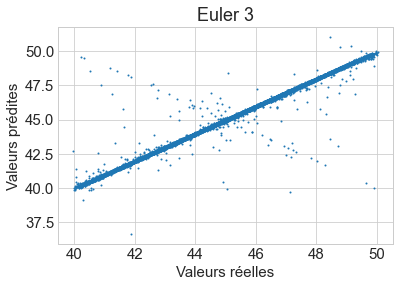

In [23]:
for i in range(3):
    axe = plt.axes()
    plt.rcParams.update({'font.size':15})
    plt.style.use('seaborn-whitegrid')
    plt.scatter(y_test[:, i], val_predictions[:, i], s=1)
    plt.title('Euler ' + str(i+1))
    axe.set(xlabel="Valeurs réelles", ylabel="Valeurs prédites")
    plt.show()

On affiche le nombre d'erreurs de 1 degré ou plus de notre modèle

In [26]:
message, rzr, sddsd, zz = pourcentage_erreur(val_predictions, y_test, X_test)
print(message)

le pourcentage d'erreur est de 0.266, 133 / 50000


on mesure la qualité de prédiction de notre modèle avec l'écart quadratique moyen, mae et le coefficient de détermination

In [27]:
run_experiment(model)

R^2 :  0.9947534609860361
MAE : 0.12463437332611109
RMSE: 2.9214493232312835


On importe d'autres données que le modèle n'a jamais vu pour le tester

In [28]:
X_3 = get_data("C_maps_3.txt")
y_3 = read_ctf("exercise3.ctf")
X_4 = get_data("C_maps_4.txt")
y_4 = read_ctf("exercise4.ctf")
X_5 = get_data("C_maps_5.txt")
y_5 = read_ctf("exercise5.ctf")

nb_ligne_matrice = 250000
Extraction des données à partir du fichier ....
ok !
nb_ligne_matrice = 250000
Extraction des données à partir du fichier ....
ok !
nb_ligne_matrice = 250000
Extraction des données à partir du fichier ....
ok !


on fait prédire nos nouvelles données et on affiche le mae du modèle sur ces nouvelles données

In [29]:
X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X_3, y_3, test_size=.2, random_state=1)
val_predictions3 = model.predict(X_3_test)
val_mae3 = mean_absolute_error(val_predictions3, y_3_test)
print("Validation MAE for Model: {}".format(val_mae3))

X_4_train, X_4_test, y_4_train, y_4_test = train_test_split(X_4, y_4, test_size=.2, random_state=1)
val_predictions4 = model.predict(X_4)
val_mae4 = mean_absolute_error(val_predictions4, y_4)
print("Validation MAE for Model: {}".format(val_mae4))

X_5_train, X_5_test, y_5_train, y_5_test = train_test_split(X_5, y_5, test_size=.2, random_state=1)
val_predictions5 = model.predict(X_5_test)
val_mae5 = mean_absolute_error(val_predictions5, y_5_test)
print("Validation MAE for Model: {}".format(val_mae5))

Validation MAE for Model: 0.13510911405588757
Validation MAE for Model: 0.14387668679500434
Validation MAE for Model: 0.14983312420094871


on affiche dans un graphique les valeurs réelles et les valeurs prédites et on observe la courbe

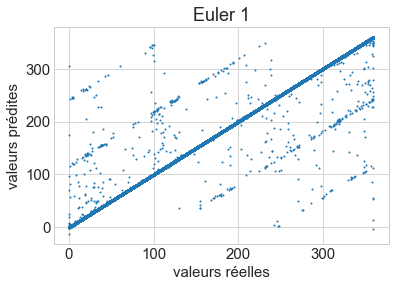

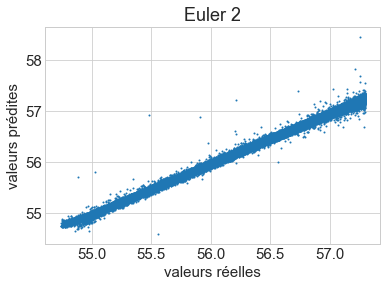

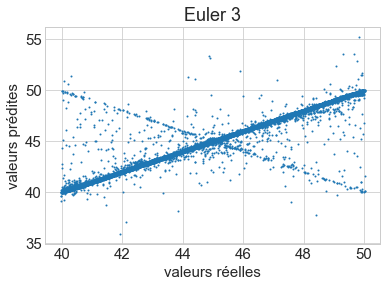

In [30]:
for i in range(3):
    axe = plt.axes()
    plt.rcParams.update({'font.size':15})
    plt.style.use('seaborn-whitegrid')
    plt.scatter(y_4[:, i], val_predictions4[:, i], s=1)
    plt.title('Euler ' + str(i+1))
    axe.set(xlabel="valeurs réelles", ylabel="valeurs prédites")
    plt.show()
# plt.scatter(X_test, y_test, label="Données d'évaluation", color="b")

on affiche le nombre d'erreurs que fait notre modèle sur ces nouvelles données

In [31]:
predictions3 = model.predict(X_3)
message3, erreur_y3, erreur_x3, err3 = pourcentage_erreur(predictions3, y_3, X_3)
print(message3)
predictions4 = model.predict(X_4)
message4, erreur_y4, erreur_x4, err4 = pourcentage_erreur(predictions4, y_4, X_4)
print(message4)
predictions5 = model.predict(X_5)
message5, erreur_y5, erreur_x5, err5 = pourcentage_erreur(predictions5, y_5, X_5)
print(message5)

le pourcentage d'erreur est de 0.2912, 728 / 250000
le pourcentage d'erreur est de 0.3048, 762 / 250000
le pourcentage d'erreur est de 0.3156, 789 / 250000


on crée un nouveau jeu de données avec les erreurs du fichier 3 et 50% aléatoire 

In [41]:
matrix_y3 = np.ones((1, 3), dtype=float)
matrix_x3 = np.ones((1, 22), dtype=float)

for i in range(err3):
    nb = np.random.randint(0, X_3.shape[0] - 1)
    matrix_y3 = np.append(matrix_y3, X_3[nb], axis=0)
    matrix_x3 = np.append(matrix_x3, y_3[nb], axis=0)
    
matrix_y3 = np.delete(matrix_x3, 0, axis=0)
matrix_x3 = np.delete(erreur_y3, 0, axis=0)
# ==============================================
matrix_y4 = np.ones((1, 3), dtype=float)
matrix_x4 = np.ones((1, 22), dtype=float)

for i in range(err4):
    nb = np.random.randint(0, X_4.shape[0] - 1)
    matrix_y4 = np.append(matrix_y4, X_4[nb], axis=0)
    matrix_x4 = np.append(matrix_x4, y_4[nb], axis=0)
    
matrix_y4 = np.delete(matrix_y4, 0, axis=0)
matrix_x4 = np.delete(matrix_x4, axis=0)
#=============================================
matrix_y5 = np.ones((1, 3), dtype=float)
matrix_x5 = np.ones((1, 22), dtype=float)

for i in range(err5):
    nb = np.random.randint(0, X_5.shape[0] - 1)
    matrix_y5 = np.append(matrix_y5, X_5[nb], axis=0)
    matrix_x5 = np.append(matrix_x5, y_5[nb], axis=0)
    
matrix_y5 = np.delete(matrix_y5, 0, axis=0)
matrix_x5 = np.delete(matrix_x5, 0, axis=0)

In [35]:
matrix_x3 = np.random.choise(X_3)
matrix_y3 = np.random.shuffle(y_3)
data_x3 = rand_x3[:err3]
data_y3 = rand_y3[:err3]
new_x3 = np.concatenate((data_x3, erreur_x3), axis=0)
new_y3 = np.concatenate((data_y3, erreur_y3), axis=0)

TypeError: 'NoneType' object is not subscriptable

In [38]:
np.random.choice(X_3[i],)

ValueError: a must be 1-dimensional

on crée un nouveau jeu de données avec les erreurs du fichier 4 et 50% aléatoire

In [ ]:
rand_x4 = np.random.shuffle(X_4)
rand_y4 = np.random.shuffle(y_4)
data_x4 = rand_x4[:err4]
data_y4 = rand_y4[:err4]
new_x4 = np.concatenate((data_x4, erreur_x4), axis=0)
new_y4 = np.concatenate((data_y4, erreur_y4), axis=0)

on crée un nouveau jeu de données avec les erreurs du fichier 5 et 50% aléatoire

In [ ]:
rand_x5 = np.random.shuffle(X_5)
rand_y5 = np.random.shuffle(y_5)
data_x5 = rand_x5[:err5]
data_y5 = rand_y5[:err5]
new_x5 = np.concatenate((data_x5, erreur_x5), axis=0)
new_y5 = np.concatenate((data_y5, erreur_y5), axis=0)

on concatene les trois matrices X et y dans une seule

In [ ]:
new_x = np.concatenate((new_x3, new_x4), axis=0)
new_y = np.concatenate((new_y3, new_y4), axis=0)
new_X = np.concatenate((new_x, new_x5), axis=0)
new_Y = np.concatenate((new_y, new_y5), axis=0)

In [ ]:
new_X.shape

In [ ]:
new_Y.shape

on sépare nos nouvelles données composé de 50% d'erreurs et 50% aléatoire en 80 % de données d'entraîenement et 20 % données de test

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(new_X, new_Y, test_size=0.2, random_state=1)

on crée un nouveau modèle avec le meme nombre de couches que le précédent

In [ ]:
model_error = keras.Sequential()

model_error.add(Input(shape=(22,)))

model_error.add(layers.Dense(256, activation="relu")),

model_error.add(layers.Dense(128, activation="relu")),

model_error.add(layers.Dense(64, activation="relu")),

model_error.add(layers.Dense(32, activation="relu")),

model_error.add(layers.Dense(3))

on donne au modèle nos nouvelles données composées de 50% d'erreurs et 50% d'aléatoires
on peut jouer avec le batch_size , le nombre d'epochs etc

In [ ]:
model_error.compile(
    optimizer="adam", 
    loss="mae", # mse
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

history = model_error.fit(
    x=X_train2, 
    y=y_train2, 
    epochs=2500,
    batch_size=1024000,
    validation_data=(X_test2, y_test2)
)

ou bien on utilise le modèle précédent ou un autres

In [ ]:
model_error = keras.models.load_model('hasan.h5')

on fait prédire à notre nouveau modèle toutes les données des trois fichiers (les modèles ne les ont jamais vu)

In [ ]:
pred3 = model_error.predict(X_3)
pred4 = model_error.predict(X_4)
pred5 = model_error.predict(X_5)

on fait aussi prédire nos données composés de 50% d'erreurs et 50% aléatoires

In [ ]:
pred = model_error.predict(new_X)

on affiche trois graphique pour visualiser la qulaité du modèle sur les données 50 50

In [ ]:
for i in range(3):
    axe = plt.axes()
    plt.rcParams.update({'font.size':15})
    plt.style.use('seaborn-whitegrid')
    plt.scatter(new_Y[:, i], pred[:, i], s=1)
    plt.title('Euler ' + str(i+1))
    axe.set(xlabel="valeurs réelles", ylabel="valeurs prédites")
    plt.show()
# plt.scatter(X_test, y_test, label="Données d'évaluation", color="b")

on affiche aussi trois graphiques pour visulaiser les performances du modèles sur toutes les données d'un des fichiers importés

In [ ]:
for i in range(3):
    axe = plt.axes()
    plt.rcParams.update({'font.size':15})
    plt.style.use('seaborn-whitegrid')
    plt.scatter(X_4[:, i], pred4[:, i], s=1)
    plt.title('Euler ' + str(i+1))
    axe.set(xlabel="valeurs réelles", ylabel="valeurs prédites")
    plt.show()
# plt.scatter(X_test, y_test, label="Données d'évaluation", color="b")

on calcule le nombre d'erreurs de 1 degré ou plus sur les données 50 50

In [ ]:
msg, erry, errx, err = pourcentage_erreur(pred, new_Y, new_X)
print(msg)

on calcule le nombre d'erreurs de 1 degré ou plus sur les trois fichiers de données

In [ ]:
message3, erreur_y3, erreur_x3, err3 = pourcentage_erreur(pred3, y_3, X_3)
print(message3)

message4, erreur_y4, erreur_x4, err4 = pourcentage_erreur(pred4, y_4, X_4)
print(message4)

message5, erreur_y5, erreur_x5, err5 = pourcentage_erreur(pred5, y_5, X_5)
print(message5)